# Observation of discrete steps in gamma-ray light curves

<h5 style="text-align:right; margin-right:15px"> 2025-04-22 11:46</h5>

## Load light curve data
Note that the file `source_info.pkl`, used here was copied from SLAC's s3df,
where is was last updated on May 10 2023 13:05. 
It can be found at `/sdf/home/b/burnett/work/bb_light_curves/files`.

* Loaded wtlike-generated variability info for 1141 sources from file `files/source_info.pkl`

* Load uw1410 and 4FGL-DR4 info for the 1141 sources 

Loaded UW model uw1410: 11786 entries
Loaded Fermi 4FGL gll_psc_v31.fit: 6659 entries


* Selected 6579 4FGL-DR4 point sources

   bll      271
   fsrq     154
   bcu      271
   unid     190
   psr       20


### Detect the single-steppers
Here I select BB light curves with exactly two blocks, and record the ratio
of the two levels (the steps), and the position of the transition.
The light curves were generated with a bin width of 7 days, so the "step" position
must be at a bin boundary, the boundary position depending on the BB algorithm, its uncertainty TBD.
Ratios close to 1.0 are possibly an artifact of the BB procedure, this needs study.

Found 100 candidates, with the association categories

,0
bcu,30
bll,40
fsrq,4
other,1
psr,1
unid,24


## Steps: ratio vs. time for blazars

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f35e94ed570>
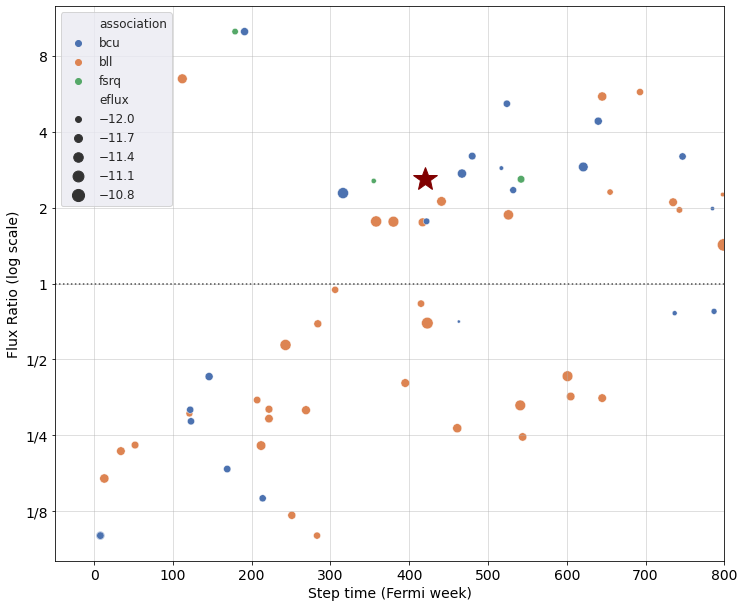

Notes:
* The star is the location, after correction for a nearby blazar, of PKS J2333-2343. Because of that, it was not included.
* There is a higher proportion of BL Lacs (15 %) than FSRQs (3 %)).
* There are more steps-up (40) than steps-down (34), and the up-steps concentrate, with higher flux ratios, at the end,
while the fewer down-steps are similarly concentrated at the start. These can be explained by the hypothesis that we are seeing transitions 
between discrete states, and the time spent in a higher state is less then the lower one. 

In [1]:
%run pylib/agn_steps
ratio_vs_time()

## Study the pulsar set to understand BB-induced background
We will compare this dataset with those for the other association categories.

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f35e9516380>
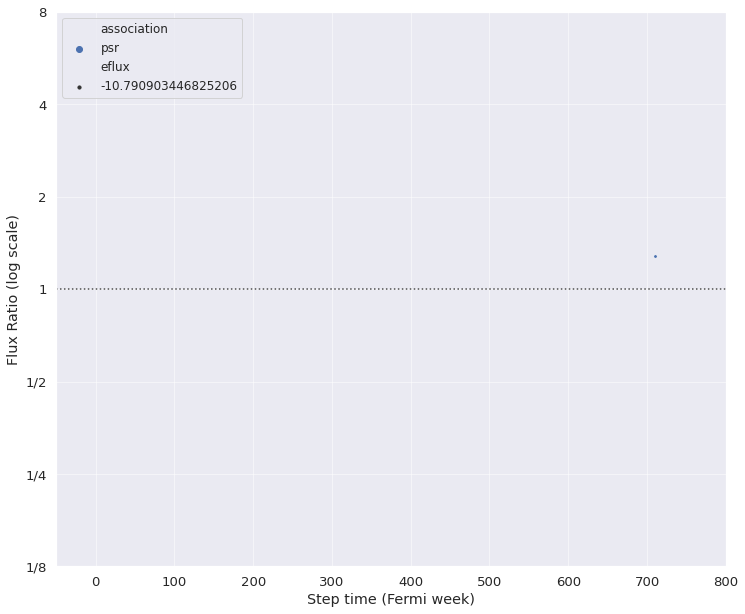

In [2]:
pulsar_only(fignum=2)

## Compare numbers of 2-block with 1
There are two reasons for 2-BB light curves to be 
related to the 1-BB ones.
1) Background: It is a false positive generated by the
BB algorithm. (We need to examine this possibility with a MC.)
2) Science: The source must have been quiet for at least 8 years, compared with 15 for 
the 1-block set. The rates must be part of same variability spectrum.

Here are the total numbers, for each of our six 
association classes:

,nbb=1,nbb=2,ratio
bcu,84,38,0.452381
bll,72,40,0.555556
fsrq,15,5,0.333333
other,14,1,0.071429
psr,14,1,0.071429
unid,95,32,0.336842


The distributions of the sizes of the steps.
The pulsar one should only reflect reason 1.

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f35e8fc7610>
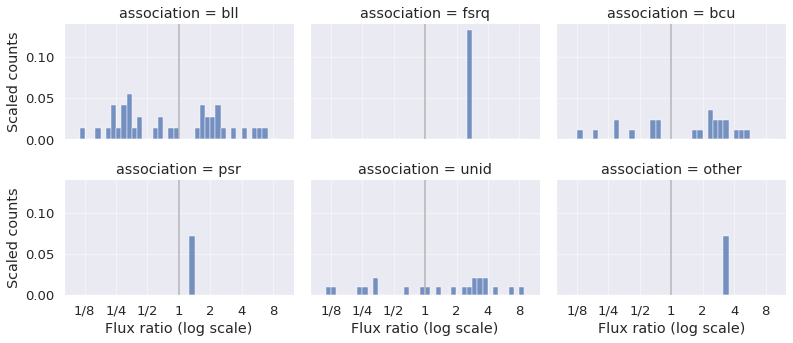

Notes:
* The range of the pulsar step sizes is 
mostly limited to be less than 2.
* If the apparent pulsar steps are all spurious, its dristribution
above shouid be a component of all the others. This does not
appear to be the case, especially for the unid's.
* The asymmetry between up- and down-steps is dramatically
different. It appears from this that the bcu's are 
BL Lacs, and a large proportion of the unid's are as well.

In [3]:
block_2_1()

In [4]:
show(f"""---
## The strongest up-steppers 
Look for those with a step in the middle...""")
bdf = df[df.association.apply(lambda a: a in 'bll fsrq bcu'.split())].sort_values('ts', ascending=False).copy()
bdfq = bdf.query('flux_ratio>1.5 & 200<time<600')
show(bdfq.head(10))
# list(bdfq.index[:10])


---
## The strongest up-steppers 
Look for those with a step in the middle...

,flux_ratio,time,ts,association,eflux,log_ratio
4FGL J0056.3-0935,1.764587,358.0,930.125602,bll,8.691760e-12,0.246643
4FGL J0308.4+0407,2.286317,316.0,709.403119,bcu,8.279307e-12,0.359136
4FGL J0013.1-3955,1.873594,526.0,687.971493,bll,5.336534e-12,0.272675
4FGL J0103.5+5337,1.760894,380.0,632.746303,bll,7.332462e-12,0.245733
4FGL J0151.3+8601,2.119410,441.0,321.257499,bll,3.917839e-12,0.326215
4FGL J0112.8-7506,1.750488,417.0,308.084714,bll,2.788927e-12,0.243159
4FGL J0237.6+0923,2.733493,467.0,157.009512,bcu,3.203594e-12,0.436718
4FGL J0319.4-7045,2.349593,532.0,87.263359,bcu,1.360863e-12,0.370993
4FGL J0058.6-1140,5.174397,524.0,53.975053,bcu,1.532873e-12,0.713860
4FGL J0317.7-2804,2.594502,542.0,45.811160,fsrq,1.707924e-12,0.414054


In [5]:
show(f"""---
## The strongest down-steppers 
Look for those with a step in the middle...""")
bdf = df[df.association.apply(lambda a: a in 'bll fsrq bcu'.split())].sort_values('ts', ascending=False).copy()
bdfq = bdf.query('flux_ratio<1/1.5 & 200<time<600')
show(bdfq.head(10))
name = bdfq.index[0]
# list(bdfq.index[:10])


---
## The strongest down-steppers 
Look for those with a step in the middle...

,flux_ratio,time,ts,association,eflux,log_ratio
4FGL J0001.2-0747,0.328709,541.0,702.004352,bll,6.967148e-12,-0.483189
4FGL J0326.2+0225,0.570864,243.0,634.655609,bll,8.446159e-12,-0.243467
4FGL J0127.2+0324,0.227629,212.0,288.568998,bll,3.831194e-12,-0.642772
4FGL J0212.4-3502,0.403116,395.0,184.692741,bll,2.621969e-12,-0.394570
4FGL J0211.1-0646,0.345073,207.0,125.554511,bll,1.626782e-12,-0.462089
4FGL J0103.8+1321,0.120370,251.0,106.607689,bll,2.061028e-12,-0.919480
4FGL J0102.4+0942,0.314535,269.0,97.142294,bll,2.893516e-12,-0.502331
4FGL J0258.1+2030,0.291121,222.0,84.876520,bll,2.404176e-12,-0.535926
4FGL J0148.6+0127,0.317273,222.0,84.267794,bll,1.885729e-12,-0.498567
4FGL J0056.8+1626,0.246297,544.0,74.024448,bll,2.343507e-12,-0.608541
